In [1]:
import os

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config

import tensorcircuit as tc
from opt_einsum import contract

import jax
from jax import numpy as jnp
from jax import random
import optax

from QDDPM_jax import setDiffusionDataOneQubit, QDDPM, HaarSampleGeneration
from distance_jax import naturalDistance, WassDistance

rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Generate data

In [3]:
def circleYGen(N_train, seed=0):
    # generate random quantum states from RY(\phi)|0>
    # assume uniform distribution
    key = random.PRNGKey(seed)
    phis = random.uniform(key, shape=(N_train,), minval=0, maxval=2*np.pi)
    states = jnp.stack((jnp.cos(phis), jnp.sin(phis)))
    states = jnp.transpose(states)

    return jnp.complex64(states)

In [20]:
n = 1
T = 40
N = 10000

diff_hs = 1.3e-3*np.arange(1, T+1)**2
diff_hs

array([1.3000e-03, 5.2000e-03, 1.1700e-02, 2.0800e-02, 3.2500e-02,
       4.6800e-02, 6.3700e-02, 8.3200e-02, 1.0530e-01, 1.3000e-01,
       1.5730e-01, 1.8720e-01, 2.1970e-01, 2.5480e-01, 2.9250e-01,
       3.3280e-01, 3.7570e-01, 4.2120e-01, 4.6930e-01, 5.2000e-01,
       5.7330e-01, 6.2920e-01, 6.8770e-01, 7.4880e-01, 8.1250e-01,
       8.7880e-01, 9.4770e-01, 1.0192e+00, 1.0933e+00, 1.1700e+00,
       1.2493e+00, 1.3312e+00, 1.4157e+00, 1.5028e+00, 1.5925e+00,
       1.6848e+00, 1.7797e+00, 1.8772e+00, 1.9773e+00, 2.0800e+00])

In [21]:
X = circleYGen(N)

Xout = np.zeros((T + 1, N, 2**n), dtype=np.complex64)
Xout[0] = X
for t in range(1, T + 1):
    Xout[t] = setDiffusionDataOneQubit(X, diff_hs[:t])
    print("Step {}".format(t))

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40


In [22]:
data_path = "./data/circle/n1"
file_name = 'circleYDiff_n1T%d_N%d.npy'%(T, N)
if not os.path.exists(data_path):
    os.makedirs(data_path)

jnp.save(os.path.join(data_path, file_name).replace("\\","/"), Xout)

Text(0.5, 0, '$t$')

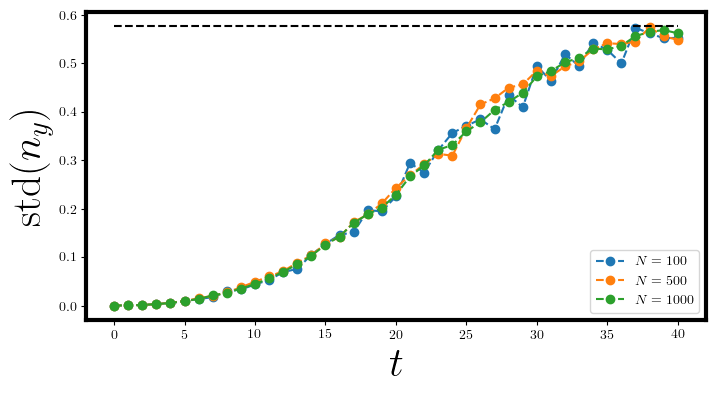

In [23]:
# plot the standard deviation of <Y>
sy = np.array([[0,-1j],[1j,0]])
X = np.load('data/circle/n1/circleYDiff_n1T%d_N%d.npy'%(T, N))
ys = contract('tmi, ij, tmj->tm', X.conj(), sy, X)

Ns = [100, 500, 1000]
plt.figure(figsize=(8, 4))
for i in range(3):
    idx = random.choice(random.PRNGKey(i), N, shape=(Ns[i], ), replace=False)
    ysample = ys[:,idx]
    plt.plot(range(T+1), np.std(ysample, axis=1), 'o--', label=r'$N=%d$'%Ns[i])
plt.plot(range(T+1), 1 / np.sqrt(3) * np.ones(T+1), '--', c='k')
plt.legend()
plt.ylabel(r'${\rm std}(n_y)$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

# Training

In [23]:
def Training_t(model, t, inputs_T, params_tot, epochs, dis_measure='wd'):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    key = random.PRNGKey(np.random.randint(low=0, high=5000))
    params_t = random.normal(key, shape=(2 * 3 * 6,))
    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate = 0.001)
    opt_state = optimizer.init(params_t)

    def loss(params_t, input_tplus1, true_data):
        output_t = model.backwardOutput_t(input_tplus1, params_t)
        if dis_measure == 'nat':
            # natural distance
            loss = naturalDistance(output_t, true_data)
        elif dis_measure == 'wd':
            # Wassastein distance
            loss = WassDistance(output_t, true_data)
        
        return loss
    
    #@partial(jax.jit, static_argnums=(2, ))
    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params_t, input_tplus1, true_data)
        print(grads.shape)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)
        return new_params_t, new_opt_state, loss_value

    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(params_t, input_tplus1, true_data, opt_state)
        
        if step % 100 == 0:
            print(f'step {step}, loss: {loss_value}')
        
        loss_hist.append(loss_value) # record the current loss

    return params_t, loss_hist

n, na = 1, 2
T = 40
L = 6

Ndata = 500
epochs = 1200

inputs_T = HaarSampleGeneration(Ndata, seed=22)
states_diff = jnp.load('data/circle/n1/circleYDiff_n1T%d_N10000.npy' %T)

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_tot = jnp.zeros((T, 2*(n + na)*L))
Training_t(model, T-1, inputs_T, params_tot, 2)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[500,500].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
def loss_fn(params, x, y):
    return jnp.sum((params * x - y) ** 2)